In [1]:
import sys

In [2]:
cd '/srv/flash1/hagrawal9/project/habitat/habitat-api/'

/coc/testnvme/hagrawal9/project/habitat/habitat-api


In [ ]:
import gzip
import json
import os
import sys
from typing import Any, Dict, List, Optional, Type
from copy import deepcopy

import attr
import cv2
import git
import magnum as mn
import numpy as np

# %matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image


import habitat
import habitat_sim
from habitat.config import Config
from habitat.core.registry import registry
from habitat_sim.utils import viz_utils as vut
from habitat.utils.visualizations import maps, fog_of_war
from habitat.utils.visualizations.utils import observations_to_image

from rearrangement.utils.planner import (
    compute_traversable_map,
    compute_distance_using_fmm,
    find_dist_from_map,
    compute_distance_mat_using_navmesh,
    compute_distance_mat_using_fmm,
    find_shortest_path_for_multiple_objects
)
from rearrangement.utils.visualization import (
    get_top_down_map, get_top_down_map_sim
)
from rearrangement.utils.geometry import (
     geodesic_distance
)
from collections import defaultdict

In [ ]:
from habitat.datasets.rearrangement.rearrangement_dataset import RearrangementDatasetV0
from habitat.tasks.rearrangement.rearrangement_task import RearrangementEpisode

In [ ]:
repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
# %cd $dir_path
data_path = os.path.join(dir_path, "data")
output_directory = "data/tutorials/output/"  # @param {type:"string"}
output_path = os.path.join(dir_path, output_directory)

In [6]:
config = habitat.get_config("configs/tasks/rearrangement_debug.yaml")

In [7]:
config.defrost()
config.TASK.SENSORS =  ["GRIPPED_OBJECT_SENSOR", "ALL_OBJECT_POSITIONS", "ALL_OBJECT_GOALS"]
config.TASK.MEASUREMENTS = ['OBJECT_TO_GOAL_DISTANCE', 'AGENT_TO_OBJECT_DISTANCE', 'TOP_DOWN_MAP']
config.DATASET.SPLIT = "val"
# config.DATASET.CONTENT_SCENES = ["rearrangement_v4_val_n=10_o=-1_Willow"]
config.freeze()

In [8]:
config.TASK.TOP_DOWN_MAP.MAP_RESOLUTION

256

In [9]:
try:
    env.close()
except:
    pass
env = habitat.Env(config)
fog_of_war_mask = None
pickup_order = {}
pickup_order_l2dist = {}

2020-11-08 20:51:16,789 Initializing dataset RearrangementDataset-v0
2020-11-08 20:51:16,974 initializing sim RearrangementSim-v0
I1108 20:51:22.172449 39776 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Willow.navmesh
I1108 20:51:22.176224 39776 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.
2020-11-08 20:51:22,470 Initializing task RearrangementTask-v0


In [10]:
len(env.episodes)

1000

In [11]:
def compute_oracle_pickup_order(env):
    # obs = env.reset()
    metrics = env.get_metrics()
    episode = env.current_episode
    metrics = env.get_metrics()

    agent_pos = env._sim.get_agent(0).get_state().position
    object_positions = [obj.position for obj in episode.objects]
    goal_positions = [obj.position for obj in episode.goals]
    
    dist_mat = compute_distance_mat_using_navmesh(env._task._simple_pathfinder, agent_pos, object_positions, goal_positions)
    route_indexes_navmesh, pickup_order_navmesh = find_shortest_path_for_multiple_objects(dist_mat)
    
#     top_down_map, fog_of_war_mask = get_top_down_map(
#         env, env._task._simple_pathfinder, ignore_objects=True, fog_of_war_mask=None, draw_fow=False, 
#         draw_agent=False, draw_object_start_pos=False, draw_object_final_pos=False, draw_object_curr_pos=False
#     )
    
    
#     a_y, a_x = maps.to_grid(
#         agent_pos[2],
#         agent_pos[0],
#         top_down_map.shape[0:2],
#         sim=env._sim,
#     )
#     grid_object_positions = []
#     grid_goal_positions = []

#     for i, obj_pos in enumerate(object_positions):
#         tdm_pos = maps.to_grid(
#             obj_pos[2],
#             obj_pos[0],
#             top_down_map.shape[0:2],
#             sim=env._sim,
#         )
#         grid_object_positions.append(tdm_pos)

#     for i, goal_pos in enumerate(goal_positions):
#         tdm_pos = maps.to_grid(
#             goal_pos[2],
#             goal_pos[0],
#             top_down_map.shape[0:2],
#             sim=env._sim,
#         )

#         grid_goal_positions.append(tdm_pos)

#     tdmap = np.copy(top_down_map[:, :, 0])
#     tdmap = tdmap / np.max(tdmap)
#     dist_mat_map = compute_distance_mat_using_fmm(tdmap, [a_y, a_x], grid_object_positions, grid_goal_positions)
    
    
#     route_indexes_map, pickup_order_map = find_shortest_path_for_multiple_objects(dist_mat_map/3)
    
    return {
        'episode_id': episode.episode_id, 
        'scene_id': episode.scene_id,
        'pickup_order': pickup_order_navmesh,
        'dist_mat': dist_mat
        # 'pickup_order_fmm': pickup_order_map 
    }

In [12]:
def compute_l2dist_pickup_order(env):
    # obs = env.reset()
    metrics = env.get_metrics()
    episode = env.current_episode
    metrics = env.get_metrics()

    agent_pos = env._sim.get_agent(0).get_state().position
    object_positions = [obj.position for obj in episode.objects]
    goal_positions = [obj.position for obj in episode.goals]
    
    dist_mat = np.zeros((   
            1 + len(object_positions) + len(goal_positions), 
            1 + len(object_positions) + len(goal_positions)
    ))
    
    for i, object_pos in enumerate([agent_pos] + object_positions + goal_positions):
        for j, goal_pos in enumerate([agent_pos] + object_positions + goal_positions):
            if j == 0:  # distance from object / goal position -> "depot" is zero
                dist = 0
            else:
                dist = np.linalg.norm(
                    np.array(object_pos) - np.array(goal_pos), ord=2
                )
            dist_mat[i][j] = dist
    
    route_indexes_map, pickup_order_map = find_shortest_path_for_multiple_objects(dist_mat)
    
    return {
        'episode_id': episode.episode_id, 
        'scene_id': episode.scene_id,
#         'pickup_order': pickup_order_navmesh,
        'pickup_order_l2dist': pickup_order_map 
    }

In [13]:
def start_env_episode_distance(env, task, episode, pickup_order):
    pathfinder = env._task._simple_pathfinder
    agent_pos = episode.start_position
    object_positions = [obj.position for obj in episode.objects]
    goal_positions = [obj.position for obj in episode.goals]

    prev_obj_end_pos = agent_pos
    shortest_dist = 0

    for i in range(len(pickup_order)):
        curr_idx = pickup_order[i] - 1
        curr_obj_start_pos = object_positions[curr_idx]
        curr_obj_end_pos = goal_positions[curr_idx]
        shortest_dist += geodesic_distance(
                pathfinder, prev_obj_end_pos, [curr_obj_start_pos]
            )

        shortest_dist += geodesic_distance(
                    pathfinder, curr_obj_start_pos, [curr_obj_end_pos]
                )
        prev_obj_end_pos = curr_obj_end_pos

    return shortest_dist

In [ ]:
# When pickup order is not known! 

l2dists = []
odists = []
l2pos = []
opos = []
ids = []
pod = {}
l2pod = {}

count = 0 
overall_count = 0
for episode in env.episodes: 
    obs = env.reset()
    odata = compute_oracle_pickup_order(env)
    l2data = compute_l2dist_pickup_order(env)
    
    pod[odata['episode_id'] + '_' + odata['scene_id']] = odata
    l2pod[l2data['episode_id'] + '_' + l2data['scene_id']] = l2data
    
    opo = odata['pickup_order']
    l2po = l2data['pickup_order_l2dist']
    opos.append(opo)
    l2pos.append(l2po)
    
    odist = start_env_episode_distance(env, env._task, env.current_episode, opo)
    l2dist = start_env_episode_distance(env, env._task, env.current_episode, l2po)
    
    # print(odist, l2dist)
    if odist == float("inf"):
        break
        
    odists.append(odist)
    l2dists.append(l2dist)
    
    ids.append(env.current_episode.scene_id + '_' + str(env.current_episode.episode_id))
    
    if(overall_count % 10 == 0):
        print(count, overall_count, sum(odists) / sum(l2dists))
    
    if l2dist > odist:
        count += 1
        # print(count, overall_count, float(count/overall_count))
        
    overall_count +=1

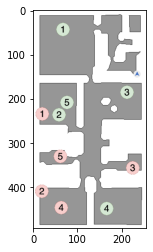

In [29]:
episode = env.current_episode
object_positions = [obj.position for obj in episode.objects]
goal_positions = [obj.position for obj in episode.goals]
agent_pos = env._sim.get_agent(0).get_state().position

top_down_map, fow_mask = get_top_down_map_sim(
            env._sim, 
            env._sim.pathfinder, 
            object_positions, 
            goal_positions,
            env._sim.navmesh_settings,
            fog_of_war_mask=None, 
            ignore_objects=True, 
            draw_fow=True, 
            draw_agent=True, 
            draw_object_start_pos=True,
            draw_object_final_pos=True
        )

plt.imshow(top_down_map)

In [21]:
odata = compute_oracle_pickup_order(env)
l2data = compute_l2dist_pickup_order(env)

In [14]:
while(len(pickup_order)!=len(env.episodes)):
    obs = env.reset()
    data = compute_oracle_pickup_order(env)
    pickup_order[data['episode_id'] + '_' + data['scene_id']] = data
    print('\rEpisode ID: {} Done: {} '.format(data['episode_id'], len(pickup_order)), end=" ")

Episode ID: 43 Done: 99  

I1108 20:53:18.059071 39776 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Castor.navmesh
I1108 20:53:18.062038 39776 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 65 Done: 199  

I1108 20:54:34.356877 39776 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Sodaville.navmesh
I1108 20:54:34.359590 39776 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 74 Done: 300  

I1108 20:55:23.977344 39776 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Maugansville.navmesh
I1108 20:55:23.980096 39776 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 78 Done: 399  

I1108 20:57:22.745759 39776 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Chrisney.navmesh
I1108 20:57:22.747848 39776 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 19 Done: 500  

I1108 20:58:37.453888 39776 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Sasakwa.navmesh
I1108 20:58:37.455564 39776 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 9 Done: 599   

I1108 21:00:01.991703 39776 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Hallettsville.navmesh
I1108 21:00:01.995042 39776 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 89 Done: 700  

I1108 21:01:48.628238 39776 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Eagerville.navmesh
I1108 21:01:48.630061 39776 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 63 Done: 799  

I1108 21:03:03.948257 39776 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Kemblesville.navmesh
I1108 21:03:03.950389 39776 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 49 Done: 899  

I1108 21:04:08.896375 39776 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Model.navmesh
I1108 21:04:08.900533 39776 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 19 Done: 1000  

In [15]:
import json_tricks

In [16]:
with open('data/pickup_order_oracle_val_v7.json','w') as f:
    json_tricks.dump(pickup_order, f)

In [17]:
while(len(pickup_order_l2dist)!=len(env.episodes)):
    obs = env.reset()
    data = compute_l2dist_pickup_order(env)
    pickup_order_l2dist[data['episode_id'] + '_' + data['scene_id']] = data
    print('\rEpisode ID: {} Done: {} '.format(data['episode_id'], len(pickup_order_l2dist)), end=" ")

I1108 21:05:55.424613 39776 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Castor.navmesh
I1108 21:05:55.428078 39776 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 10 Done: 99  

I1108 21:07:09.325384 39776 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Sasakwa.navmesh
I1108 21:07:09.327215 39776 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 21 Done: 200  

I1108 21:08:31.721498 39776 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Kemblesville.navmesh
I1108 21:08:31.723323 39776 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 15 Done: 300  

I1108 21:09:35.642491 39776 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Willow.navmesh
I1108 21:09:35.646057 39776 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 92 Done: 400  

I1108 21:11:26.242646 39776 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Sodaville.navmesh
I1108 21:11:26.244493 39776 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 64 Done: 499  

I1108 21:12:15.040109 39776 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Model.navmesh
I1108 21:12:15.043438 39776 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 97 Done: 599  

I1108 21:14:00.868211 39776 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Maugansville.navmesh
I1108 21:14:00.870471 39776 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 49 Done: 699  

I1108 21:15:57.370590 39776 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Eagerville.navmesh
I1108 21:15:57.373672 39776 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 70 Done: 799  

I1108 21:17:12.090963 39776 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Hallettsville.navmesh
I1108 21:17:12.092614 39776 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 95 Done: 899  

I1108 21:18:58.635459 39776 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Chrisney.navmesh
I1108 21:18:58.638805 39776 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.


Episode ID: 45 Done: 1000  

In [18]:
with open('data/pickup_order_l2dist_val_v7.json','w') as f:
    json_tricks.dump(pickup_order_l2dist, f)

In [19]:
with open('data/pickup_order_l2dist_val_v7.json','r') as f:
    pickup_order_l2dist = json_tricks.load(f)
    
with open('data/pickup_order_oracle_val_v7.json','r') as f:
    pickup_order = json_tricks.load(f)

In [21]:
updated_scene_data = []
split = 'val'

for filename in os.listdir('data/datasets/rearrangement/gibson/v1/{}/content/'.format(split)):
    scene_id = filename.split('.')[0].split('_')[-1]
    with gzip.open('data/datasets/rearrangement/gibson/v1/{}/content/'.format(split) + filename, "rt") as f:
        scene_data = json.load(f)
    
    updated_scene_data = deepcopy(scene_data)
    
    for i, episode in enumerate(scene_data['episodes']):
        episode_id = episode['episode_id']
        assert updated_scene_data['episodes'][i]['episode_id'] == episode['episode_id']
        assert updated_scene_data['episodes'][i]['scene_id'] == episode['scene_id']
        updated_scene_data['episodes'][i]['pickup_order'] = pickup_order[str(episode['episode_id']) + "_" + episode['scene_id']]['pickup_order']
        updated_scene_data['episodes'][i]['pickup_order_l2dist'] = pickup_order_l2dist[str(episode['episode_id']) + "_" + episode['scene_id']]['pickup_order_l2dist']
    
        if 'Kemble' in episode['scene_id']:
            print(episode['episode_id'])
            print(updated_scene_data['episodes'][i]['pickup_order'])
            print(updated_scene_data['episodes'][i]['pickup_order_l2dist'])
        
    with gzip.open('data/datasets/rearrangement/gibson/v1/{}/content/'.format(split) + filename, "wt") as f:
        json.dump(updated_scene_data, f)
        
    print(filename)
    
#     if 'Kemble' in filename:
#         break

rearrangement_hard_v7_val_n=100_o=5_t=0.9_Hallettsville.json.gz
rearrangement_hard_v7_val_n=100_o=5_t=0.95_Maugansville.json.gz
rearrangement_hard_v7_val_n=100_o=5_t=0.9_Sodaville.json.gz
rearrangement_hard_v7_val_n=100_o=5_t=0.95_Willow.json.gz
0
[3, 4, 5, 1, 2]
[3, 4, 5, 2, 1]
1
[5, 4, 3, 1, 2]
[3, 4, 5, 2, 1]
2
[4, 5, 2, 1, 3]
[1, 3, 4, 5, 2]
3
[5, 2, 3, 1, 4]
[4, 2, 1, 3, 5]
4
[1, 4, 3, 2, 5]
[3, 1, 2, 5, 4]
5
[3, 5, 4, 1, 2]
[3, 4, 2, 1, 5]
6
[2, 3, 5, 1, 4]
[2, 3, 1, 5, 4]
7
[4, 1, 2, 5, 3]
[4, 5, 2, 3, 1]
8
[3, 5, 1, 2, 4]
[4, 3, 5, 1, 2]
9
[2, 1, 5, 4, 3]
[1, 4, 2, 5, 3]
10
[4, 2, 1, 3, 5]
[4, 3, 5, 2, 1]
11
[5, 3, 2, 1, 4]
[4, 1, 5, 3, 2]
12
[3, 1, 2, 4, 5]
[4, 3, 1, 5, 2]
13
[3, 4, 1, 5, 2]
[4, 1, 5, 2, 3]
14
[1, 2, 5, 3, 4]
[1, 3, 4, 2, 5]
15
[2, 1, 4, 5, 3]
[2, 3, 5, 1, 4]
16
[4, 1, 5, 3, 2]
[3, 1, 5, 4, 2]
17
[1, 2, 4, 5, 3]
[1, 4, 2, 3, 5]
18
[3, 5, 2, 4, 1]
[2, 5, 1, 4, 3]
19
[3, 4, 2, 5, 1]
[5, 1, 4, 2, 3]
20
[4, 1, 2, 3, 5]
[4, 5, 2, 1, 3]
21
[2, 5, 3, 4, 1]
[1, 2, 3, 

In [31]:
pwd

'/coc/testnvme/hagrawal9/project/habitat/habitat-api'

In [65]:
for episode in scene_data['episodes']:
    if 'Kemble' in episode['scene_id']:
        print(episode['episode_id'])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [63]:
scene_data['episodes']

[{'episode_id': 0,
  'scene_id': 'data/scene_datasets/gibson_train_val/Chrisney.glb',
  'start_position': [-0.19770857691764832,
   0.1829099953174591,
   -0.41612085700035095],
  'start_rotation': [0.0, 0.0, 0.0, 1.0],
  'info': {},
  'objects': [{'object_id': 0,
    'object_handle': 'data/ycb/003_cracker_box.phys_properties.json',
    'position': [0.7775579690933228, 0.2896284759044647, -0.9832146167755127],
    'rotation': [-0.4999999701976776,
     0.4999999701976776,
     0.4999999701976776,
     0.4999999701976776]},
   {'object_id': 1,
    'object_handle': 'data/ycb/012_strawberry.phys_properties.json',
    'position': [2.499708890914917, 0.20574750006198883, -1.1965395212173462],
    'rotation': [-0.4999999701976776,
     0.4999999701976776,
     0.4999999701976776,
     0.4999999701976776]},
   {'object_id': 2,
    'object_handle': 'data/ycb/008_pudding_box.phys_properties.json',
    'position': [3.99869441986084, 0.20235450565814972, -0.5074211359024048],
    'rotation': [-0.